In [ ]:
# ============================================
# Cell 1: Imports & Strict Repro
# ============================================
import os, math, random, time, csv, copy, json
from collections import defaultdict, deque
from dataclasses import dataclass
from typing import List, Tuple, Dict, Any

os.environ.setdefault("CUBLAS_WORKSPACE_CONFIG", ":16:8")

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import torchvision
import torchvision.transforms as T
import matplotlib.pyplot as plt

# Repro
SEED = 1337
random.seed(SEED); np.random.seed(SEED)
torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)

STRICT_REPRO = True
if STRICT_REPRO:
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    try:
        torch.use_deterministic_algorithms(True, warn_only=True)
    except Exception:
        pass
else:
    torch.backends.cudnn.benchmark = True

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)

# Deterministic worker/generator
g = torch.Generator(); g.manual_seed(SEED)
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed); random.seed(worker_seed)


Device: cuda


In [ ]:
# ============================================
# Cell 2: Champion Config (CoCoNAS v3.2)
# ============================================

# Dataset split: CIFAR-100 → 10 tasks × 10 classes
NUM_CLASSES = 100
TASK_SIZE = 10
TASKS = [list(range(i, i+TASK_SIZE)) for i in range(0, NUM_CLASSES, TASK_SIZE)]

# Per-class samples (train/val), test uses full CIFAR100 test per task
TRAIN_PER_CLASS = 400
VAL_PER_CLASS   = 100

# Exemplar budget (train-only memory)
EXEMPLAR_TOTAL_BUDGET = 2000

# Device/latency simulation profile
EDGE_PROFILE = os.environ.get("COCONAS_EDGE", "nano_int8")  # "nano_int8"|"xaviernx_fp16"|"orin_nano_fp16"|"none"
JETSON_SIM_FACTOR = {"nano_int8": 12.0, "xaviernx_fp16": 6.0, "orin_nano_fp16": 4.0}
JETSON_TARGET_MS  = {"nano_int8": 10.6,  "xaviernx_fp16": 6.0, "orin_nano_fp16": 4.0}

# === Champion knobs (locked) ===
REWARD_MODE   = "lagrangian"
STAB_ALPHA    = 0.20
ENABLE_STAB_REWARD = True
STAB_GAMMA    = 0.10   # <-- Champion γ
ENTROPY_WEIGHT_IN_REWARD = 0.01
USE_CVAR      = True
CVAR_TAU      = 0.20
CVAR_BATCHES  = 8

# Constraint modes
RELAXED_CONSTRAINT = True                # Champion mainline: relaxed 12.0ms
TIGHT_LAT_TARGET   = float(os.environ.get("COCONAS_LAT_MS", "10.6"))
if EDGE_PROFILE in JETSON_TARGET_MS: TIGHT_LAT_TARGET = JETSON_TARGET_MS[EDGE_PROFILE]
RELAXED_LAT_TARGET = 12.0
LAT_TARGET_MS      = RELAXED_LAT_TARGET if RELAXED_CONSTRAINT else TIGHT_LAT_TARGET

# v3.2 feasibility slack & frontier bonus
LAT_SLACK_FRAC = 0.06   # allow +6% over target in relaxed mode
SLACK_BONUS    = 0.03   # small bonus if within allowed

# Optional size penalty (off by default)
ENABLE_SIZE_PEN = False
LAM_SIZE        = 0.04

# Lagrangian dual update
DUAL_LR    = 0.005
U_CLIP_MAX = 10.0
MARGIN_MS  = 0.0   # not used in v3.2 (we use slack boundary instead)

# Controller slots & exploration bump
MAX_HEADS       = 16
TEMP_START, TEMP_END = 7.0, 0.9   # exploration bump
EPS_FLOOR       = 0.10
BOOTSTRAP_ROUNDS= 4

# HP grid for HP controller
from itertools import product
HP_GRID = {
    "KD_W":   [0.45, 0.60, 0.70],
    "KD_T":   [2.0, 3.0],
    "LR":     [7e-4, 5e-4],
    "REPLAY": [(0.55,0.25,0.20), (0.45,0.25,0.30)],
    "BFT":    [50, 150]
}
HP_KEYS    = list(HP_GRID.keys())
HP_OPTIONS = [HP_GRID[k] for k in HP_KEYS]
HP_ACTIONS = [dict(zip(HP_KEYS, vals)) for vals in product(*HP_OPTIONS)]

# Training basics
IMG_SIZE = 224
BATCH_SIZE    = 64
LR_WARMUP     = 1e-3
LR_RL         = 7e-4
LR_CONSOLID   = 5e-4
WD            = 1e-4
GRAD_CLIP     = 1.0

# Scheduling
FAST_DEBUG           = False
WARMUP_STEPS_PER_HEAD= 200 if not FAST_DEBUG else 30
RL_ITERS             = 600 if not FAST_DEBUG else 150
TRAIN_STEPS_PER_PICK = 8   if not FAST_DEBUG else 2
CONSOLIDATION_STEPS  = 300 if not FAST_DEBUG else 60
BALANCED_FT_STEPS    = 150 if not FAST_DEBUG else 30
EQ_TOPK              = 3
EQ_STEPS             = 100     # Champion: equalized fine-tune of top-3 heads (100 steps)
EQ_LR                = LR_CONSOLID

# Error buffer (prioritized)
ERRBUF_CAPACITY_PER_TASK = 800
PRIORITY_ALPHA   = 0.6
HARD_PERCENTILE  = 0.75
BOOST_K_CLASSES  = 2
BOOST_FACTOR     = 2.0

# Evolution
POP_SIZE = 6
MUTATE_EVERY = 100 if not FAST_DEBUG else 50
OFFSPRING_PER_CYCLE = 2
MAX_LAYERS = 4
WIDTH_CHUNK = 64
DROP_CHOICES = [0.0, 0.2, 0.5]
SAL_EMA_BETA = 0.9
SAL_MIN_STEPS = 50

# Risk-driven mutations
RISK_DRIVEN_MUTATIONS = True  # Champion: ON

# KD schedule
def kd_weight_for_task(t): return min(0.30 + 0.05 * t, 0.70)

# Artifacts
ART_DIR = "coconas_v32_artifacts"


In [ ]:
# ============================================
# Cell 3: Utilities (dirs, artifacts, banner)
# ============================================
def ensure_dir(path):
    if not os.path.exists(path):
        os.makedirs(path, exist_ok=True)

ensure_dir(ART_DIR)

def dump_task_artifact(task_id: int, payload: dict, art_dir: str = None):
    art_dir = ART_DIR if art_dir is None else art_dir
    ensure_dir(ART_DIR)
    fname = os.path.join(art_dir, f"task_{task_id+1:02d}.json")
    with open(fname, "w") as f:
        json.dump(payload, f, indent=2)
    print(f"[ART] Wrote {fname}")

def print_run_banner():
    print("\n" + "="*70)
    print(" CoCoNAS v3.2 — Champion Run Config")
    print("="*70)
    mode = "RELAXED" if RELAXED_CONSTRAINT else "TIGHT"
    print(f" Constraint Mode        : {mode}")
    print(f"  - TIGHT_LAT_TARGET    : {TIGHT_LAT_TARGET} ms")
    print(f"  - RELAXED_LAT_TARGET  : {RELAXED_LAT_TARGET} ms")
    print(f"  - LAT_TARGET_MS (used): {LAT_TARGET_MS} ms")
    print(f"  - LAT_SLACK_FRAC      : {LAT_SLACK_FRAC}")
    print(f"  - SLACK_BONUS         : {SLACK_BONUS}")
    print(f" Edge Profile           : {EDGE_PROFILE}")
    print(f" Reward Mode            : {REWARD_MODE}")
    print(f" Stability Reward (γ)   : {ENABLE_STAB_REWARD} (γ={STAB_GAMMA})")
    print(f"  - STAB_ALPHA (blend)  : {STAB_ALPHA}")
    print(f"  - USE_CVAR            : {USE_CVAR} (tau={CVAR_TAU}, batches={CVAR_BATCHES})")
    print(f" Entropy Weight         : {ENTROPY_WEIGHT_IN_REWARD}")
    print(f" Risk-Driven Mutations  : {RISK_DRIVEN_MUTATIONS}")
    print(f" Exploration            : TEMP {TEMP_START}->{TEMP_END}, EPS_FLOOR={EPS_FLOOR}")
    print(f" BOOTSTRAP_ROUNDS       : {BOOTSTRAP_ROUNDS}")
    print(f" POP_SIZE / MAX_HEADS   : {POP_SIZE} / {MAX_HEADS}")
    print(f" RL_ITERS               : {RL_ITERS}")
    print(f" Artifacts Dir          : {ART_DIR}")
    print("="*70 + "\n")


In [ ]:
# ============================================
# Cell 4: Datasets, Splits, Loaders
# ============================================
class IndexDataset(Dataset):
    def __init__(self, base: Dataset, indices: List[int]):
        self.base = base; self.indices = list(indices)
    def __len__(self): return len(self.indices)
    def __getitem__(self, i):
        img, label = self.base[self.indices[i]]
        return img, int(label), int(self.indices[i])

def build_indices_by_class(base_plain: Dataset, num_classes=NUM_CLASSES):
    buckets = {c: [] for c in range(num_classes)}
    for i in range(len(base_plain)):
        _, y = base_plain[i]
        buckets[int(y)].append(i)
    return buckets

def split_task_indices(train_buckets, cls_list, train_per=TRAIN_PER_CLASS, val_per=VAL_PER_CLASS):
    tr_idx, vo_idx = [], []
    for c in cls_list:
        idxs = list(train_buckets[c])
        random.Random(SEED + c).shuffle(idxs)
        assert len(idxs) >= train_per + val_per, f"Not enough data for class {c}"
        tr_idx += idxs[:train_per]
        vo_idx += idxs[train_per:train_per+val_per]
    return tr_idx, vo_idx

# Transforms
train_base = torchvision.datasets.CIFAR100(root="./data", train=True,  download=True, transform=T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
]))
val_base   = torchvision.datasets.CIFAR100(root="./data", train=True,  download=False, transform=T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
    T.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
]))
test_base  = torchvision.datasets.CIFAR100(root="./data", train=False, download=True, transform=T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
    T.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
]))

# Label-only for indexing
plain_train = torchvision.datasets.CIFAR100(root="./data", train=True,  download=False, transform=T.ToTensor())
plain_test  = torchvision.datasets.CIFAR100(root="./data", train=False, download=False, transform=T.ToTensor())
train_buckets = build_indices_by_class(plain_train)
test_buckets  = build_indices_by_class(plain_test)

def make_task_splits(task_classes):
    tr_idx, vo_idx = split_task_indices(train_buckets, task_classes)
    te_idx = []
    for c in task_classes: te_idx += test_buckets[c]
    return IndexDataset(train_base, tr_idx), IndexDataset(val_base, vo_idx), IndexDataset(test_base, te_idx)

def make_test_dataset_for_task(task_classes):
    idx = []
    for c in task_classes: idx += test_buckets[c]
    return IndexDataset(test_base, idx)

def make_loader(ds, shuffle, bs=BATCH_SIZE, drop_last=False):
    if ds is None: return None
    return DataLoader(
        ds, batch_size=bs, shuffle=shuffle, num_workers=2, pin_memory=True,
        drop_last=drop_last, worker_init_fn=seed_worker, generator=g,
    )

def leak_check(ds_train, ds_val):
    inter = set(ds_train.indices) & set(ds_val.indices)
    assert len(inter) == 0, f"LEAK: {len(inter)} overlapping samples!"

def leak_check_threeway(ds_train, ds_val, ds_test):
    s_tr, s_va = set(ds_train.indices), set(ds_val.indices)
    assert s_tr.isdisjoint(s_va), "LEAK: train↔val overlap"


100%|██████████| 169M/169M [00:03<00:00, 48.2MB/s]


In [ ]:
# ============================================
# Cell 5: Backbone & Head Builder
# ============================================
from torchvision.models import resnet18

class BackboneGAP(nn.Module):
    def __init__(self):
        super().__init__()
        try:
            m = resnet18(weights=torchvision.models.ResNet18_Weights.IMAGENET1K_V1)
        except Exception:
            try:
                m = resnet18(pretrained=True)
            except Exception:
                m = resnet18(weights=None)
        self.features = nn.Sequential(*list(m.children())[:-1])
        for p in self.features.parameters(): p.requires_grad = False
    def forward(self, x):
        x = self.features(x)
        return x.flatten(1)  # GAP → 512

class FCHead(nn.Module):
    def __init__(self, in_dim=512, hidden=[256], p_drop=0.0, out_dim=NUM_CLASSES):
        super().__init__()
        layers = []; prev = in_dim
        for h in hidden:
            layers += [nn.Linear(prev, h), nn.ReLU(inplace=True)]
            if p_drop>0: layers += [nn.Dropout(p_drop)]
            prev = h
        layers += [nn.Linear(prev, out_dim)]
        self.net = nn.Sequential(*layers)
        self.hidden = list(hidden); self.p_drop = p_drop
    def forward(self, z): return self.net(z)

def count_params(m): return sum(p.numel() for p in m.parameters() if p.requires_grad)

# Seed heads (random configs + two anchors)
RANDOM_SEED_POP = True
N_RANDOM_SEEDS  = 8
WIDTH_SET   = [64, 128, 256, 384, 512]
DEPTH_RANGE = (0, 4)

def make_seed_head_configs():
    rng = random.Random(SEED + 42)
    cfgs = []
    for _ in range(N_RANDOM_SEEDS):
        d = rng.randint(DEPTH_RANGE[0], DEPTH_RANGE[1])
        hidden = [rng.choice(WIDTH_SET) for _ in range(d)]
        p_drop = rng.choice([0.0, 0.2, 0.5])
        cfgs.append(dict(hidden=hidden, p_drop=p_drop))
    cfgs.append(dict(hidden=[], p_drop=0.0))
    cfgs.append(dict(hidden=[512,512,512,512][:DEPTH_RANGE[1]], p_drop=0.5))
    return cfgs

def build_seed_heads(out_dim=NUM_CLASSES):
    heads = {}
    for i, cfg in enumerate(make_seed_head_configs()):
        h = FCHead(out_dim=out_dim, **cfg).to(DEVICE)
        h._sal_tracker = None
        heads[f"H{i}"] = h
    return heads

backbone = BackboneGAP().to(DEVICE).eval()
seed_heads = build_seed_heads()
print({k: {"hidden": v.hidden, "p_drop": v.p_drop} for k, v in seed_heads.items()})
print("Backbone ready; GAP=512. Seed heads:", len(seed_heads))


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 185MB/s]


{'H0': {'hidden': [128, 384], 'p_drop': 0.5}, 'H1': {'hidden': [256], 'p_drop': 0.2}, 'H2': {'hidden': [384], 'p_drop': 0.5}, 'H3': {'hidden': [64, 64, 384, 64], 'p_drop': 0.2}, 'H4': {'hidden': [256], 'p_drop': 0.5}, 'H5': {'hidden': [64, 256], 'p_drop': 0.5}, 'H6': {'hidden': [512, 512, 512], 'p_drop': 0.5}, 'H7': {'hidden': [], 'p_drop': 0.2}, 'H8': {'hidden': [], 'p_drop': 0.0}, 'H9': {'hidden': [512, 512, 512, 512], 'p_drop': 0.5}}
Backbone ready; GAP=512. Seed heads: 10


In [ ]:
# ============================================
# Cell 6: Feature Caching (Z-space dataset)
# ============================================
class FeatureDS(Dataset):
    def __init__(self, base_idx_ds: Dataset, backbone: nn.Module, bs=256):
        self.Z, self.Y, self.I = [], [], []
        loader = DataLoader(
            base_idx_ds, batch_size=bs, shuffle=False, num_workers=2, pin_memory=True,
            worker_init_fn=seed_worker, generator=g
        )
        backbone.eval()
        with torch.no_grad():
            for x,y,i in loader:
                z = backbone(x.to(DEVICE)).cpu()
                self.Z.append(z); self.Y.append(y.clone()); self.I.append(i.clone().cpu().int())
        self.Z = torch.cat(self.Z); self.Y = torch.cat(self.Y); self.I = torch.cat(self.I)
    def __len__(self): return self.Y.size(0)
    def __getitem__(self, k): return self.Z[k], int(self.Y[k]), int(self.I[k])


In [ ]:
# ============================================
# Cell 7: Buffers (Error & Exemplar Memory)
# ============================================
class ErrorBufferZ:
    def __init__(self, capacity=ERRBUF_CAPACITY_PER_TASK):
        self.capacity = capacity
        self.items = []
        self.per_class = defaultdict(int)
    def __len__(self): return len(self.items)
    def add_batch(self, z, y, losses, class_cap=80):
        z = z.detach().cpu(); y = y.detach().cpu(); losses = losses.detach().cpu()
        for i in range(len(y)):
            c = int(y[i])
            if self.per_class[c] >= class_cap: continue
            self.items.append({"z": z[i], "y": int(y[i]), "loss_val": float(losses[i]), "cls": c})
            self.per_class[c] += 1
        if len(self.items) > self.capacity:
            fifo_k = max(1, int(0.2*self.capacity))
            tail = self.items[-fifo_k:]
            rest = sorted(self.items[:-fifo_k], key=lambda d: d["loss_val"], reverse=True)[:self.capacity - fifo_k]
            self.items = rest + tail
    def sample(self, n, boost_classes=None, boost_factor=BOOST_FACTOR):
        if not self.items: return None
        w = torch.tensor([max(1e-6, d["loss_val"]) for d in self.items], dtype=torch.float)
        if boost_classes:
            for i,d in enumerate(self.items):
                if d["cls"] in boost_classes: w[i] *= boost_factor
        w = (w ** PRIORITY_ALPHA); w = w / w.sum()
        idx = torch.multinomial(w, num_samples=min(n, len(self.items)), replacement=False).tolist()
        Z, Y = [], []
        for i in idx: Z.append(self.items[i]["z"]); Y.append(self.items[i]["y"])
        return torch.stack(Z).to(DEVICE), torch.tensor(Y, device=DEVICE)

class ExemplarMemoryZ:
    def __init__(self, budget=EXEMPLAR_TOTAL_BUDGET, seed=0):
        self.budget = int(budget)
        self.store  = {}  # c -> [(z_cpu, c), ...]
        random.seed(seed)
    def size(self):
        return sum(len(v) for v in self.store.values())
    @torch.no_grad()
    def sample(self, n, seen_classes):
        items = []
        for c in seen_classes:
            items.extend(self.store.get(int(c), []))
        if len(items) == 0: return None
        take = min(int(n), len(items))
        idx  = np.random.choice(len(items), size=take, replace=(len(items) < take))
        z = torch.stack([items[i][0] for i in idx]).to(DEVICE)
        y = torch.tensor([items[i][1] for i in idx], device=DEVICE)
        return z, y
    @torch.no_grad()
    def update_after_task_risk(self, ds_train_z, per_class_k):
        # truncate over-quota
        for c, k in per_class_k.items():
            c = int(c); k = int(k)
            if c in self.store and len(self.store[c]) > k:
                self.store[c] = self.store[c][:k]
        # top-up pass
        need = {int(c): max(0, int(per_class_k.get(int(c), 0)) - len(self.store.get(int(c), [])))
                for c in per_class_k.keys()}
        if sum(need.values()) > 0:
            for i in range(len(ds_train_z)):
                z, y, _ = ds_train_z[i]
                c = int(y)
                if c in need and need[c] > 0:
                    self.store.setdefault(c, []).append((z.cpu(), c))
                    need[c] -= 1
                    if sum(need.values()) == 0: break
        # budget fit
        total = self.size()
        if total > self.budget:
            scale = self.budget / float(total)
            for c in list(self.store.keys()):
                keep = max(0, int(round(len(self.store[c]) * scale)))
                self.store[c] = self.store[c][:keep]

exemplar_mem = ExemplarMemoryZ()


In [ ]:
# ============================================
# Cell 8: Eval Helpers (masking, accuracy, latency)
# ============================================
criterion = nn.CrossEntropyLoss(reduction='none')

def mask_unseen_logits(logits: torch.Tensor, seen_classes):
    if not seen_classes: return logits
    mask = torch.full_like(logits, float("-inf"))
    mask[:, list(seen_classes)] = 0.0
    return logits + mask

def masked_ce(logits, y, seen_classes):
    if not seen_classes: return criterion(logits, y)
    mask = torch.full_like(logits, -1e9)
    mask[:, list(seen_classes)] = 0.0
    return criterion(logits + mask, y)

@torch.no_grad()
def logits_any(head, x):
    if x.dim() == 4:
        z = backbone(x.to(DEVICE))
    else:
        z = x.to(DEVICE)
    return head(z)

@torch.no_grad()
def eval_accuracy_any(backbone_unused, head, loader, seen_classes=None):
    if loader is None: return 0.0
    correct, total = 0, 0
    for x,y,_ in loader:
        y = y.to(DEVICE)
        logits = logits_any(head, x)
        logits = mask_unseen_logits(logits, seen_classes)
        pred = logits.argmax(1)
        correct += (pred==y).sum().item(); total += y.numel()
    return correct / max(1,total)

@torch.no_grad()
def accuracy_cvar(backbone_unused, head, loader, seen_classes=None, tau=CVAR_TAU, batches=CVAR_BATCHES):
    if loader is None: return 0.0
    accs = []
    for bi,(x,y,_) in enumerate(loader):
        if bi >= batches: break
        y = y.to(DEVICE)
        logits = logits_any(head, x)
        logits = mask_unseen_logits(logits, seen_classes)
        pred = logits.argmax(1)
        accs.append((pred==y).float().mean().item())
    if not accs: return 0.0
    accs = sorted(accs)
    k = max(1, int(math.ceil(tau*len(accs))))
    return float(np.mean(accs[:k]))

@torch.no_grad()
def worst_k_classes_on_val_any(backbone_unused, head, val_loader, k=2, seen_classes=None):
    if k<=0 or val_loader is None: return []
    cls_c, cls_t = defaultdict(int), defaultdict(int)
    for x,y,_ in val_loader:
        y = y.to(DEVICE)
        logits = logits_any(head, x)
        logits = mask_unseen_logits(logits, seen_classes)
        pred = logits.argmax(1)
        for yi,pi in zip(y.tolist(), pred.tolist()):
            cls_t[yi]+=1
            if yi==pi: cls_c[yi]+=1
    accs = [(c, cls_c[c]/max(1,cls_t[c])) for c in cls_t.keys()]
    accs.sort(key=lambda t: t[1])
    return [c for c,_ in accs[:k]]

@torch.no_grad()
def latency_stats_ms_per_image(backbone_model, head, bs=32, iters=60, warmup=20):
    model = nn.Sequential(backbone_model, head).to(DEVICE).eval()
    x = torch.randn(bs, 3, IMG_SIZE, IMG_SIZE, device=DEVICE)
    times = []
    if DEVICE.type == 'cuda':
        s = torch.cuda.Event(enable_timing=True); e = torch.cuda.Event(enable_timing=True)
        for _ in range(warmup): _ = model(x); torch.cuda.synchronize()
        for _ in range(iters):
            s.record(); _ = model(x); e.record()
            torch.cuda.synchronize()
            times.append(s.elapsed_time(e) / bs)
    else:
        for _ in range(warmup): _ = model(x)
        for _ in range(iters):
            t0=time.time(); _ = model(x); t1=time.time()
            times.append((t1-t0)*1000.0/bs)
    t=torch.tensor(times)
    p50 = float(torch.quantile(t,0.5)); p95=float(torch.quantile(t,0.95))
    return p50, p95

def cache_head_latency_stats(head_dict, bs=32):
    stats={}
    for name, head in head_dict.items():
        p50,p95=latency_stats_ms_per_image(backbone, head, bs=bs)
        if EDGE_PROFILE in JETSON_SIM_FACTOR: p95 *= JETSON_SIM_FACTOR[EDGE_PROFILE]
        stats[name]={"p50":p50,"p95":p95}
    return stats

def seen_up_to(task_id: int):     return list(range((task_id+1)*TASK_SIZE))
def old_seen_up_to(task_id: int): return list(range(task_id*TASK_SIZE))


In [ ]:
# ============================================
# Cell 9: Saliency + Train Step (KD)
# ============================================
class SaliencyTracker:
    def __init__(self, beta=SAL_EMA_BETA): self.beta=beta; self.ema={}; self.steps=0
    def update_from_head(self, head: nn.Module):
        self.steps += 1
        li = -1
        for m in head.net:
            if isinstance(m, nn.Linear):
                li += 1
                g = m.weight.grad
                if g is None: continue
                val = g.detach().abs().mean().item()
                key = f"L{li}"; prev = self.ema.get(key, val)
                self.ema[key] = self.beta*prev + (1-self.beta)*val
    def hottest_layer(self):
        if not self.ema: return "L0"
        return max(self.ema.items(), key=lambda kv: kv[1])[0]

def train_step_kd_z(head, opt, z, y, teacher_head=None, old_classes=None, kd_weight=0.5, kd_T=2.0, seen_classes=None):
    head.train()
    logits = head(z)
    ce = masked_ce(logits, y, seen_classes).mean()
    loss = ce
    if teacher_head is not None and old_classes:
        with torch.no_grad(): t_logits = teacher_head(z)
        old_mask = torch.isin(y, torch.tensor(old_classes, device=y.device))
        if old_mask.any():
            student_logits_old = logits[old_mask][:, old_classes]
            teacher_logits_old = t_logits[old_mask][:, old_classes]
            ps = F.log_softmax(student_logits_old / kd_T, dim=1)
            pt = F.softmax(teacher_logits_old / kd_T, dim=1)
            kd = F.kl_div(ps, pt, reduction='batchmean') * (kd_T**2)
            loss = (1-kd_weight)*loss + kd_weight*kd
    opt.zero_grad(); loss.backward()
    if hasattr(head, "_sal_tracker") and head._sal_tracker is not None:
        head._sal_tracker.update_from_head(head)
    nn.utils.clip_grad_norm_(head.parameters(), GRAD_CLIP)
    opt.step()
    with torch.no_grad():
        mis = (logits.argmax(1)!=y)
        per_ex = masked_ce(logits.detach(), y.detach(), seen_classes)
    return float(loss.item()), per_ex.detach(), mis.detach()


In [ ]:
# ============================================
# Cell 10: Evolution (mutate, net2net, population)
# ============================================
def clone_cfg(cfg): return dict(hidden=list(cfg.get('hidden', [])), p_drop=float(cfg.get('p_drop', 0.0)))

def mutate_cfg(cfg, sal_tracker: SaliencyTracker=None, high_risk_classes: List[int] = None):
    new = clone_cfg(cfg)
    hidden = new['hidden']
    ops = ['widen', 'narrow', 'add_layer', 'drop_layer', 'tweak_drop']
    if RISK_DRIVEN_MUTATIONS and high_risk_classes:
        weights = [4, 1, 3, 0.5, 1]
    else:
        weights = [3, 2, 2, 1, 1]
    target_li = None
    if sal_tracker is not None and sal_tracker.steps >= SAL_MIN_STEPS and sal_tracker.ema:
        target_li = int((sal_tracker.hottest_layer())[1:])
    op = random.choices(ops, weights=weights, k=1)[0]
    if op == 'widen' and len(hidden)>0:
        li = min(target_li if target_li is not None else random.randrange(len(hidden)), len(hidden)-1)
        hidden[li] = min(((hidden[li]+WIDTH_CHUNK-1)//WIDTH_CHUNK)*WIDTH_CHUNK + WIDTH_CHUNK, 512)
    elif op == 'narrow' and len(hidden)>0:
        li = random.randrange(len(hidden))
        hidden[li] = max(((hidden[li]-1)//WIDTH_CHUNK)*WIDTH_CHUNK - WIDTH_CHUNK, WIDTH_CHUNK)
    elif op == 'add_layer' and len(hidden) < MAX_LAYERS:
        k = random.randrange(len(hidden)+1); hidden.insert(k, WIDTH_CHUNK)
    elif op == 'drop_layer' and len(hidden) > 0:
        k = random.randrange(len(hidden)); hidden.pop(k)
    elif op == 'tweak_drop':
        new['p_drop'] = random.choice([0.0,0.2,0.5])
    new['hidden'] = [h for h in hidden if h >= WIDTH_CHUNK][:MAX_LAYERS]
    return new

@torch.no_grad()
def net2net_transfer(parent: FCHead, child: FCHead):
    p_layers = [m for m in parent.net if isinstance(m, nn.Linear)]
    c_layers = [m for m in child.net  if isinstance(m, nn.Linear)]
    k = min(len(p_layers), len(c_layers))
    for i in range(k):
        Pw, Pb = p_layers[i].weight.data, p_layers[i].bias.data
        Cw, Cb = c_layers[i].weight.data, c_layers[i].bias.data
        in_k = min(Pw.size(1), Cw.size(1))
        out_k= min(Pw.size(0), Cw.size(0))
        Cw[:out_k, :in_k] = Pw[:out_k, :in_k]
        Cb[:out_k] = Pb[:out_k]

class Population:
    def __init__(self, initial: Dict[str, FCHead]):
        self.members = {}
        for name, head in initial.items():
            cfg = dict(hidden=head.hidden, p_drop=head.p_drop)
            opt = torch.optim.AdamW(head.parameters(), lr=LR_RL, weight_decay=WD)
            p50, p95 = latency_stats_ms_per_image(backbone, head, bs=32)
            if EDGE_PROFILE in JETSON_SIM_FACTOR: p95 *= JETSON_SIM_FACTOR[EDGE_PROFILE]
            self.members[name] = {'head': head, 'cfg': cfg, 'opt': opt, 'p95': p95, 'name': name}
        self.counter = 0
    def add_child(self, parent_name: str, high_risk_classes: List[int] = None):
        parent = self.members[parent_name]
        p_cfg = parent['cfg']; sal = parent['head']._sal_tracker
        c_cfg = mutate_cfg(p_cfg, sal_tracker=sal, high_risk_classes=high_risk_classes)
        child = build_head_from_cfg(c_cfg)
        net2net_transfer(parent['head'], child)
        opt = torch.optim.AdamW(child.parameters(), lr=LR_RL, weight_decay=WD)
        p50, p95 = latency_stats_ms_per_image(backbone, child, bs=32)
        if EDGE_PROFILE in JETSON_SIM_FACTOR: p95 *= JETSON_SIM_FACTOR[EDGE_PROFILE]
        cname = f"E{len(self.members)}"
        self.members[cname] = {'head': child, 'cfg': c_cfg, 'opt': opt, 'p95': p95, 'name': cname}
        return cname
    def prune_to(self, running_R: Dict[str, List[float]], keep=POP_SIZE):
        if len(self.members) <= keep: return
        perf = []
        for name in self.members.keys():
            avg_r = np.mean(running_R.get(name) or [-1e9])
            perf.append((name, avg_r))
        perf.sort(key=lambda x: x[1], reverse=True)
        kept_names = {name for name, _ in perf[:keep]}
        self.members = {name: slot for name, slot in self.members.items() if name in kept_names}

def build_head_from_cfg(cfg, out_dim=NUM_CLASSES):
    h = FCHead(in_dim=512, hidden=cfg.get('hidden', []), p_drop=cfg.get('p_drop', 0.0), out_dim=out_dim).to(DEVICE)
    h._sal_tracker = SaliencyTracker()
    return h


In [ ]:
# ============================================
# Cell 11: Controllers (masked softmax + exploration)
# ============================================
class Policy(nn.Module):
    def __init__(self, state_dim, out_dim, hid=64):
        super().__init__()
        self.enc = nn.Sequential(nn.Linear(state_dim, hid), nn.ReLU(), nn.Linear(hid, hid), nn.ReLU())
        self.logits = nn.Linear(hid, out_dim)
    def forward(self, s): return self.logits(self.enc(s))

class SoftmaxController:
    def __init__(self, out_dim, state_dim):
        self.out_dim = out_dim
        self.state_dim = state_dim
        self.policy = Policy(state_dim, out_dim).to(DEVICE)
        self.opt = torch.optim.Adam(self.policy.parameters(), lr=1e-3)
        self.baseline = 0.0; self.beta = 0.9
        self.temp = TEMP_START; self.step = 0
    def select(self, state_vec):
        self.step += 1
        self.temp = max(TEMP_END, TEMP_START - (TEMP_START - TEMP_END)*(self.step/max(1,RL_ITERS)))
        with torch.no_grad():
            logits = self.policy(state_vec.unsqueeze(0)) / self.temp
            probs  = torch.softmax(logits, -1).squeeze(0)
            probs  = (1 - EPS_FLOOR)*probs + EPS_FLOOR/self.out_dim
            k = torch.multinomial(probs, 1).item()
        return k, probs.detach().cpu()
    def select_masked(self, state_vec, mask_vec):
        self.step += 1
        self.temp = max(TEMP_END, TEMP_START - (TEMP_START - TEMP_END)*(self.step/max(1,RL_ITERS)))
        with torch.no_grad():
            logits = self.policy(state_vec.unsqueeze(0))
            masked_logits = logits.masked_fill(mask_vec.unsqueeze(0) == 0, float("-inf"))
            probs = torch.softmax(masked_logits / self.temp, -1).squeeze(0)
            active = mask_vec.sum().clamp(min=1)
            probs = (1 - EPS_FLOOR)*probs + EPS_FLOOR/active * mask_vec
            probs = probs / probs.sum()
            k = torch.multinomial(probs, 1).item()
        return k, probs.detach().cpu()
    def update(self, state_vec, action_k, reward):
        logits = self.policy(state_vec.unsqueeze(0))
        logp = torch.log_softmax(logits, -1)[0, action_k]
        adv  = reward - self.baseline
        probs= torch.softmax(logits, -1)
        ent  = -(probs * torch.log_softmax(logits, -1)).sum()
        loss = -adv*logp - 0.02*ent
        self.opt.zero_grad(); loss.backward(); self.opt.step()
        self.baseline = self.beta*self.baseline + (1-self.beta)*reward



In [ ]:
# ============================================
# Cell 12: Reward (v3.2 slack + bonus + size opt)
# ============================================
def compute_reward_any(
    head,
    val_loader_now,
    latency_p95_ms,
    dual_u=None,
    entropy_weight=ENTROPY_WEIGHT_IN_REWARD,
    seen_classes=None,
    prev_val_loader=None,
    prev_seen_classes=None,
    size_mb=None
):
    # Accuracy terms
    if USE_CVAR:
        acc_now = accuracy_cvar(None, head, val_loader_now, seen_classes=seen_classes)
    else:
        acc_now = eval_accuracy_any(None, head, val_loader_now, seen_classes=seen_classes)

    if prev_val_loader is not None and prev_seen_classes:
        if USE_CVAR:
            acc_old = accuracy_cvar(None, head, prev_val_loader, seen_classes=prev_seen_classes)
        else:
            acc_old = eval_accuracy_any(None, head, prev_val_loader, seen_classes=prev_seen_classes)
    else:
        acc_old = 0.0

    acc_blend = (1.0 - STAB_ALPHA) * acc_now + STAB_ALPHA * acc_old

    # entropy probe
    H_vals = []
    for bi,(x,_,_) in enumerate(val_loader_now):
        if bi >= 2: break
        logits = logits_any(head, x)
        logits = mask_unseen_logits(logits, seen_classes)
        p = torch.softmax(logits, 1)
        H_vals.append((-(p*torch.log(p+1e-9)).sum(1)).mean().item())
    H = float(sum(H_vals)/max(1,len(H_vals))) if H_vals else 0.0

    # v3.2: slack-aware boundary & frontier bonus
    allowed_over = LAT_TARGET_MS * (1.0 + (LAT_SLACK_FRAC if RELAXED_CONSTRAINT else 0.0))
    within_allowed = (latency_p95_ms <= allowed_over)

    if REWARD_MODE == "lagrangian":
        u = 0.0 if dual_u is None else float(dual_u)
        g = max(0.0, latency_p95_ms - allowed_over)
        if ENABLE_STAB_REWARD:
            base_R = acc_now - u * g - entropy_weight * H
            R = (1.0 - STAB_GAMMA) * base_R + STAB_GAMMA * acc_old
        else:
            R = acc_blend - u * g - entropy_weight * H
        if within_allowed: R += SLACK_BONUS
        if ENABLE_SIZE_PEN and (size_mb is not None):
            R -= LAM_SIZE * max(0.0, float(size_mb))
        return R, acc_now, acc_old, H, g

    else:
        if ENABLE_STAB_REWARD:
            base_R = acc_now - 0.02 * latency_p95_ms - entropy_weight * H
            R = (1.0 - STAB_GAMMA) * base_R + STAB_GAMMA * acc_old
        else:
            R = acc_blend - 0.02 * latency_p95_ms - entropy_weight * H
        if within_allowed: R += SLACK_BONUS
        if ENABLE_SIZE_PEN and (size_mb is not None):
            R -= LAM_SIZE * max(0.0, float(size_mb))
        return R, acc_now, acc_old, H, None


In [ ]:
# ============================================
# Cell 13: Risk-aware exemplar allocation (VAL-driven)
# ============================================
def risk_aware_k_per_class(loader_val, head, seen_classes, tau=CVAR_TAU):
    from collections import defaultdict
    cls_acc = defaultdict(list)
    with torch.no_grad():
        for bi, (x, y, _) in enumerate(loader_val):
            y = y.to(DEVICE)
            logits = logits_any(head, x)
            logits = mask_unseen_logits(logits, seen_classes)
            pred = logits.argmax(1)
            correct = (pred == y).detach().cpu().tolist()
            for yi, ok in zip(y.detach().cpu().tolist(), correct):
                cls_acc[yi].append(1.0 if ok else 0.0)
            if bi >= 10:
                break
    risks = {}
    for c in seen_classes:
        accs = sorted(cls_acc.get(c, [0.0]))
        k = max(1, int(math.ceil(tau * len(accs))))
        cvar_acc = float(np.mean(accs[:k]))
        risks[c] = 1.0 - cvar_acc
    s = sum(risks.values()) + 1e-9
    base_per_class = max(1, EXEMPLAR_TOTAL_BUDGET // max(1, len(seen_classes)))
    per_class_k = {}
    for c in seen_classes:
        w = risks[c] / s if s > 0 else 1.0 / max(1, len(seen_classes))
        per_class_k[c] = max(0, int(round(w * base_per_class * len(seen_classes))))
    return per_class_k


In [ ]:
# ============================================
# Cell 14: CSV Logger (optional)
# ============================================
class CSVLogger:
    def __init__(self, path):
        self.path = path
        with open(self.path, "w", newline="") as f:
            csv.writer(f).writerow(
                ["phase","iter","head","hp_id","acc_val","acc_old","reward","p95_ms","g","u","errbuf","exmem","cfg"]
            )
    def log(self, phase, it, head, hp_id, acc, acc_old, R, p95, g, u, errn, exn, cfg):
        with open(self.path, "a", newline="") as f:
            csv.writer(f).writerow([
                phase, it, head, f"{hp_id}", f"{acc:.4f}", f"{acc_old:.4f}",
                f"{R:.4f}", f"{p95:.3f}",
                "" if g is None else f"{g:.3f}",
                f"{u:.3f}", errn, exn, cfg
            ])


In [ ]:
# ============================================
# Cell 15: RL Runner (v3.2)
# ============================================
def build_state_vec(last_reward, step_frac, last_head_onehot, errbuf_size, ex_mem_size, lat_min, lat_max, lat_current):
    sr = torch.tensor([max(0.0, min(1.0, (last_reward + 1.0)/2.0))], device=DEVICE)
    sf = torch.tensor([step_frac], device=DEVICE)
    eb = torch.tensor([min(1.0, errbuf_size/1000.0)], device=DEVICE)
    em = torch.tensor([min(1.0, ex_mem_size/max(1,EXEMPLAR_TOTAL_BUDGET))], device=DEVICE)
    if lat_max <= lat_min: lat_min, lat_max = 0.0, max(1.0, lat_current)
    ln = torch.tensor([(lat_current - lat_min)/max(1e-6, (lat_max - lat_min))], device=DEVICE)
    return torch.cat([sr, sf, eb, em, ln, last_head_onehot.to(DEVICE)], dim=0)

def run_all_tasks(save_json_path="artifacts_v32_run.json"):
    print_run_banner()
    lat_cache = cache_head_latency_stats(seed_heads, bs=32)
    print("Latency p95 (ms):", {n: round(lat_cache[n]['p95'],2) for n in seed_heads})

    head_opt = {n: torch.optim.AdamW(h.parameters(), lr=LR_WARMUP, weight_decay=WD) for n,h in seed_heads.items()}
    task_test_datasets = [make_test_dataset_for_task(TASKS[t]) for t in range(len(TASKS))]

    acc_history_rows = []; best_head_per_task = []
    val_acc_history_rows = []
    val_history_z = []; train_history_z = []

    prev_teacher = None
    dual_u = 0.0

    STATE_DIM = 5 + MAX_HEADS
    head_ctrl = SoftmaxController(out_dim=MAX_HEADS, state_dim=STATE_DIM)
    hp_ctrl   = SoftmaxController(out_dim=len(HP_ACTIONS), state_dim=STATE_DIM)
    last_head_slot = 0

    all_artifacts = {"meta": {
        "RISK_DRIVEN_MUTATIONS": bool(RISK_DRIVEN_MUTATIONS),
        "LAT_TARGET_MS": LAT_TARGET_MS, "LAT_SLACK_FRAC": LAT_SLACK_FRAC,
        "POP_SIZE": POP_SIZE, "MAX_HEADS": MAX_HEADS, "RL_ITERS": RL_ITERS
    }, "tasks": []}

    WARMUP_T0 = WARMUP_STEPS_PER_HEAD
    WARMUP_TN = max(20, WARMUP_STEPS_PER_HEAD // 4)

    bind_steps = 0
    total_steps = 0

    for task_id, task_classes in enumerate(TASKS):
        print(f"\n==== Task {task_id+1}/{len(TASKS)} — classes {task_classes} ====")
        ds_train, ds_val, ds_test_cur = make_task_splits(task_classes)
        leak_check(ds_train, ds_val); leak_check_threeway(ds_train, ds_val, ds_test_cur)

        ds_train_z = FeatureDS(ds_train, backbone, bs=256)
        ds_val_z   = FeatureDS(ds_val,   backbone, bs=256)

        loader_train_z = DataLoader(ds_train_z, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2, pin_memory=True,
                                    drop_last=True, worker_init_fn=seed_worker, generator=g)
        loader_val_z   = DataLoader(ds_val_z,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True,
                                    worker_init_fn=seed_worker, generator=g)

        prev_train_ds    = ConcatDataset(train_history_z) if len(train_history_z)>0 else None
        loader_prev_train= make_loader(prev_train_ds, shuffle=True, bs=BATCH_SIZE)

        prev_val_ds    = ConcatDataset(val_history_z) if len(val_history_z)>0 else None
        loader_prev_val= make_loader(prev_val_ds, shuffle=False, bs=BATCH_SIZE)

        errbuf = ErrorBufferZ(capacity=ERRBUF_CAPACITY_PER_TASK)
        logger = CSVLogger(f"run_task{task_id+1}.csv")

        _train_iter = iter(loader_train_z)
        def sample_train_batch_z():
            nonlocal _train_iter
            try: z,y,i = next(_train_iter)
            except StopIteration:
                _train_iter = iter(loader_train_z); z,y,i = next(_train_iter)
            return z.to(DEVICE), y.to(DEVICE)

        def build_mixed_batch_z(replay_tuple, boost_classes=None):
            tr_p, err_p, ex_p = replay_tuple
            zt, yt = sample_train_batch_z()
            n = zt.size(0)
            take_err = int(err_p*n); take_mem = int(ex_p*n)
            ze=ye=zm=ym=None
            if take_err>0:
                s = errbuf.sample(take_err, boost_classes=boost_classes, boost_factor=BOOST_FACTOR)
                if s is not None: ze, ye = s
            if take_mem>0:
                s = exemplar_mem.sample(take_mem, seen_up_to(task_id))
                if s is not None: zm, ym = s
            Z=[zt]; Y=[yt]
            if ze is not None: Z.append(ze); Y.append(ye)
            if zm is not None: Z.append(zm); Y.append(ym)
            return zt, yt, torch.cat(Z,0), torch.cat(Y,0)

        KD_W = kd_weight_for_task(task_id)
        print(f"KD weight base={KD_W:.2f}")

        # ---- Warm-up seed heads
        head_names = list(seed_heads.keys())
        warmup_R = {}
        steps_this_task = WARMUP_T0 if task_id == 0 else WARMUP_TN
        seen_classes = seen_up_to(task_id)
        old_classes  = old_seen_up_to(task_id)
        for name in head_names:
            head = seed_heads[name]; opt = head_opt[name]
            head._sal_tracker = SaliencyTracker()
            for gpg in opt.param_groups: gpg["lr"]=LR_WARMUP
            for _ in range(steps_this_task):
                zt, yt, zmix, ymix = build_mixed_batch_z((0.67,0.25,0.08))
                loss, losses, mis = train_step_kd_z(head, opt, zmix, ymix,
                                                    teacher_head=prev_teacher, old_classes=old_classes,
                                                    kd_weight=KD_W, kd_T=2.0, seen_classes=seen_classes)
                train_losses = losses[:BATCH_SIZE]
                add_mask = (mis[:BATCH_SIZE] | (train_losses > train_losses.quantile(HARD_PERCENTILE)))
                if add_mask.any(): errbuf.add_batch(zt[add_mask], yt[add_mask], train_losses[add_mask])
            R, acc_now, acc_old, H, g_val = compute_reward_any(
                head, loader_val_z, latency_p95_ms=lat_cache[name]["p95"],
                dual_u=0.0, seen_classes=seen_classes, prev_val_loader=loader_prev_val,
                prev_seen_classes=old_classes
            )
            warmup_R[name]=R
            print(f"[Warmup] {name}: acc_now={acc_now:.3f} R={R:.3f} p95={lat_cache[name]['p95']:.2f}ms")
            logger.log("warmup", steps_this_task, name, -1, acc_now, acc_old, R, lat_cache[name]["p95"], g_val, 0.0, len(errbuf), exemplar_mem.size(), str(seed_heads[name].hidden))

        # ---- Build population from top-K
        keep = sorted(warmup_R.items(), key=lambda kv: kv[1], reverse=True)[:4]
        head_names = [n for n,_ in keep]
        pop = Population({n: seed_heads[n] for n in head_names})
        head_names = list(pop.members.keys())

        last_reward = 0.0
        lat_min = min(pop.members[n]["p95"] for n in head_names)
        lat_max = max(pop.members[n]["p95"] for n in head_names)
        running_R = {n: [] for n in head_names}
        sel_count = defaultdict(int)

        task_art = {
            "task_id": task_id,
            "classes": task_classes,
            "u_trace": [], "g_trace": [],
            "head_pick_trace": [],
            "head_cfgs_end": None,
            "constraint_bind_ratio": None
        }

        for it in range(RL_ITERS):
            seen_classes = seen_up_to(task_id); old_classes  = old_seen_up_to(task_id)

            # boost risky classes occasionally
            if BOOST_K_CLASSES>0 and (it % 10 == 0):
                probe_name = head_names[last_head_slot % len(head_names)]
                boost_classes = worst_k_classes_on_val_any(None, pop.members[probe_name]['head'],
                                                           loader_val_z, k=BOOST_K_CLASSES, seen_classes=seen_classes)
            else:
                boost_classes = []

            # Active mask
            head_names = list(pop.members.keys())
            active_mask = torch.zeros(MAX_HEADS, device=DEVICE)
            active_mask[:len(head_names)] = 1.0

            # v3.2 Feasibility guard (+slack if relaxed)
            feas_vec = torch.zeros(MAX_HEADS, device=DEVICE)
            allowed_over = LAT_TARGET_MS * (1.0 + (LAT_SLACK_FRAC if RELAXED_CONSTRAINT else 0.0))
            for idx, nm in enumerate(head_names):
                p95_ms = float(pop.members[nm]["p95"])
                feas_vec[idx] = 1.0 if (p95_ms <= allowed_over) else 0.0
            mask_vec = (active_mask * feas_vec)
            if mask_vec.sum() == 0: mask_vec = active_mask.clone()

            # one-hot of last head
            onehot = torch.zeros(MAX_HEADS, device=DEVICE)
            if last_head_slot < len(head_names): onehot[last_head_slot] = 1.0
            p95_for_state = pop.members[head_names[last_head_slot % len(head_names)]]["p95"]

            state = build_state_vec(last_reward, it/max(1,RL_ITERS), onehot, len(errbuf),
                                    exemplar_mem.size(), lat_min, lat_max, p95_for_state)

            # Head selection
            if it < BOOTSTRAP_ROUNDS * len(head_names):
                slot_k = it % len(head_names)
            else:
                slot_k, _ = head_ctrl.select_masked(state, mask_vec)
                if slot_k >= len(head_names): slot_k = slot_k % len(head_names)

            name = head_names[slot_k]
            slot = pop.members[name]
            head = slot['head']; opt = slot['opt']
            sel_count[name]+=1; last_head_slot = slot_k

            # HP selection
            hp_k, _ = hp_ctrl.select(state)
            hp = HP_ACTIONS[hp_k]
            for gpg in opt.param_groups: gpg["lr"]=hp["LR"]
            replay_tuple = hp["REPLAY"]; KDw = hp["KD_W"]; kdT = hp["KD_T"]

            # Train few steps on mixed TRAIN
            for _ in range(TRAIN_STEPS_PER_PICK):
                zt, yt, zmix, ymix = build_mixed_batch_z(replay_tuple, boost_classes=boost_classes)
                loss, losses, mis = train_step_kd_z(head, opt, zmix, ymix,
                                                    teacher_head=prev_teacher, old_classes=old_classes,
                                                    kd_weight=KDw, kd_T=kdT, seen_classes=seen_classes)
                train_losses = losses[:BATCH_SIZE]
                add_mask = (mis[:BATCH_SIZE] | (train_losses > train_losses.quantile(HARD_PERCENTILE)))
                if add_mask.any(): errbuf.add_batch(zt[add_mask], yt[add_mask], train_losses[add_mask])

            # Optional quick rehearsal on previous TRAIN
            if loader_prev_train is not None and prev_teacher is not None:
                for (zp, yp, _) in loader_prev_train:
                    zp, yp = zp.to(DEVICE), yp.to(DEVICE)
                    _ = train_step_kd_z(head, opt, zp, yp,
                                        teacher_head=prev_teacher, old_classes=old_classes,
                                        kd_weight=min(0.70, KDw+0.10), kd_T=kdT, seen_classes=seen_classes)
                    break

            # Reward/eval on VAL
            p95 = slot['p95']
            R, acc_now, acc_old, H, g_val = compute_reward_any(
                head, loader_val_z, latency_p95_ms=p95, dual_u=dual_u,
                seen_classes=seen_classes, prev_val_loader=loader_prev_val, prev_seen_classes=old_classes
            )
            head_ctrl.update(state, slot_k, R); hp_ctrl.update(state, hp_k, R)

            if g_val is not None:
                total_steps += 1
                if g_val > 0: bind_steps += 1
                dual_u = min(U_CLIP_MAX, max(0.0, dual_u + DUAL_LR * g_val))

            running_R[name].append(R); last_reward=R

            if (it+1)%50==0:
                print(f"[RL {it+1:04d}] {name} | acc_now={acc_now:.3f} R={R:.3f} p95={p95:.2f} | g={(g_val or 0):.2f} | u={dual_u:.3f} | errbuf={len(errbuf)}")
            logger.log("rl", it+1, name, hp_k, acc_now, acc_old, R, p95, g_val, dual_u, len(errbuf), exemplar_mem.size(), str(slot['cfg']))

            # artifacts trace
            task_art["u_trace"].append(float(dual_u))
            task_art["g_trace"].append(float(g_val if g_val is not None else 0.0))
            task_art["head_pick_trace"].append({"iter": int(it+1), "name": name})

            # Evolution
            if (it+1) % MUTATE_EVERY == 0:
                avgR = {n: (np.mean(running_R.get(n, [0])) if running_R.get(n) else -1e9) for n in head_names}
                parent_name = max(avgR.items(), key=lambda kv: kv[1])[0]
                parent_head = pop.members[parent_name]['head']
                high_risk_classes = worst_k_classes_on_val_any(None, parent_head, loader_val_z,
                                                               k=BOOST_K_CLASSES, seen_classes=seen_classes)
                print(f"[Evolve] Parent {parent_name} riskiest on {high_risk_classes}.")
                for _ in range(OFFSPRING_PER_CYCLE):
                    child_name = pop.add_child(parent_name, high_risk_classes=(high_risk_classes if RISK_DRIVEN_MUTATIONS else None))
                    running_R[child_name] = []
                pop.prune_to(running_R, keep=POP_SIZE)
                head_names = list(pop.members.keys())
                lat_min = min(pop.members[n]["p95"] for n in head_names)
                lat_max = max(pop.members[n]["p95"] for n in head_names)
                last_head_slot = 0

        # ===== Equalized Fine-Tune of Top-3 & final pick =====
        board=[]
        print("\nFinal head leaderboard (pre-EQ):")
        for name in head_names:
            head = pop.members[name]['head']; p95 = pop.members[name]['p95']
            avgR  = float(np.mean(running_R[name])) if running_R[name] else -1e9
            Rf, acc_now, acc_old, Hf, gf = compute_reward_any(
                head, loader_val_z, latency_p95_ms=p95, dual_u=dual_u,
                seen_classes=seen_up_to(task_id), prev_val_loader=loader_prev_val, prev_seen_classes=old_seen_up_to(task_id))
            acc_blend = (1-STAB_ALPHA)*acc_now + STAB_ALPHA*acc_old
            print(f"{name:>3}  picks={len(running_R[name]):>4}  avgR={avgR:>6.3f}  acc_now={acc_now:>6.3f}  acc_old={acc_old:>6.3f}  acc_blend={acc_blend:>6.3f}  p95={p95:.2f}")
            board.append(dict(name=name, avgR=avgR, acc_now=acc_now, acc_old=acc_old, acc_blend=acc_blend, p95=p95))
        board.sort(key=lambda t: (t["acc_blend"], t["avgR"]), reverse=True)

        candidates = [b["name"] for b in board[:min(EQ_TOPK, len(board))]]
        print(f"\n[EQ] Equalized fine-tune on: {candidates}  (steps={EQ_STEPS})")
        old_classes  = old_seen_up_to(task_id); seen_classes = seen_up_to(task_id)
        for cname in candidates:
            head = pop.members[cname]['head']
            opt_eq = torch.optim.AdamW(head.parameters(), lr=EQ_LR, weight_decay=WD)
            for _ in range(EQ_STEPS):
                zt, yt, zmix, ymix = build_mixed_batch_z((0.60,0.25,0.15))
                _ = train_step_kd_z(head, opt_eq, zmix, ymix,
                                    teacher_head=prev_teacher, old_classes=old_classes,
                                    kd_weight=kd_weight_for_task(task_id), kd_T=2.0, seen_classes=seen_classes)

        board_eq=[]
        print("\nFinal head leaderboard (post-EQ):")
        for name in head_names:
            head = pop.members[name]['head']; p95 = pop.members[name]['p95']
            Rf, acc_now, acc_old, Hf, gf = compute_reward_any(
                head, loader_val_z, latency_p95_ms=p95, dual_u=dual_u,
                seen_classes=seen_up_to(task_id), prev_val_loader=loader_prev_val, prev_seen_classes=old_seen_up_to(task_id))
            acc_blend = (1-STAB_ALPHA)*acc_now + STAB_ALPHA*acc_old
            avgR  = float(np.mean(running_R[name])) if running_R[name] else -1e9
            print(f"{name:>3}  acc_now={acc_now:>6.3f}  acc_old={acc_old:>6.3f}  acc_blend={acc_blend:>6.3f}  p95={p95:.2f}")
            board_eq.append(dict(name=name, avgR=avgR, acc_now=acc_now, acc_old=acc_old, acc_blend=acc_blend, p95=p95))
        board_eq.sort(key=lambda t: (t["acc_blend"], t["avgR"]), reverse=True)

        best_name = board_eq[0]["name"]; best_head = pop.members[best_name]['head']
        print("\nChosen head:", best_name, pop.members[best_name]['cfg']); best_head_per_task.append(best_name)

        # task artifact end snapshot
        task_art["head_cfgs_end"] = {n: pop.members[n]['cfg'] for n in head_names}
        ratio = (100.0*bind_steps/max(1,total_steps))
        task_art["constraint_bind_ratio"] = ratio
        print(f"Constraint bound in {bind_steps}/{total_steps} steps ({ratio:.1f}%).  Final u={dual_u:.3f}")
        bind_steps = 0; total_steps = 0

        # Consolidation & balanced FT on exemplars
        opt = torch.optim.AdamW(best_head.parameters(), lr=LR_CONSOLID, weight_decay=WD)
        if loader_prev_train is not None and prev_teacher is not None:
            prev_loader = DataLoader(ConcatDataset(train_history_z), batch_size=BATCH_SIZE,
                                     shuffle=True, num_workers=2, pin_memory=True, drop_last=True,
                                     worker_init_fn=seed_worker, generator=g)
            steps = min(200, CONSOLIDATION_STEPS // 2)
            for _ in range(steps):
                for z,y,_ in prev_loader:
                    z, y = z.to(DEVICE), y.to(DEVICE)
                    _ = train_step_kd_z(best_head, opt, z, y,
                                        teacher_head=prev_teacher, old_classes=old_classes,
                                        kd_weight=kd_weight_for_task(task_id), kd_T=2.0, seen_classes=seen_classes)
                    break

        for _ in range(CONSOLIDATION_STEPS):
            zt, yt, zmix, ymix = build_mixed_batch_z((0.6,0.25,0.15))
            _ = train_step_kd_z(best_head, opt, zmix, ymix,
                                teacher_head=prev_teacher, old_classes=old_classes,
                                kd_weight=kd_weight_for_task(task_id), kd_T=2.0, seen_classes=seen_classes)

        for _ in range(BALANCED_FT_STEPS):
            s = exemplar_mem.sample(BATCH_SIZE, seen_classes)
            if s is None: break
            zm, ym = s
            _ = train_step_kd_z(best_head, opt, zm, ym,
                                teacher_head=prev_teacher, old_classes=seen_classes,
                                kd_weight=kd_weight_for_task(task_id), kd_T=2.0, seen_classes=seen_classes)

        # Risk-aware exemplars
        per_class_k = risk_aware_k_per_class(loader_val_z, best_head, seen_classes)
        exemplar_mem.update_after_task_risk(ds_train_z, per_class_k)
        for ds_prev_train in train_history_z + [ds_train_z]:
            exemplar_mem.update_after_task_risk(ds_prev_train, per_class_k)
        if exemplar_mem.size() > EXEMPLAR_TOTAL_BUDGET:
            total = exemplar_mem.size()
            scale = EXEMPLAR_TOTAL_BUDGET / float(total)
            for c in list(exemplar_mem.store.keys()):
                keep = max(0, int(round(len(exemplar_mem.store[c]) * scale)))
                exemplar_mem.store[c] = exemplar_mem.store[c][:keep]

        expected_total = sum(int(per_class_k.get(c, 0)) for c in seen_classes)
        print(f"Exemplar memory size: {exemplar_mem.size()} (expected ≈ {expected_total})")

        # Eval cumulative on TEST
        row_acc=[]
        for i in range(task_id+1):
            ds_test_i = task_test_datasets[i]
            loader_test_i = make_loader(ds_test_i, shuffle=False, bs=BATCH_SIZE)
            acc_i = eval_accuracy_any(None, best_head, loader_test_i, seen_classes=seen_up_to(i))
            row_acc.append(acc_i)
        acc_history_rows.append(row_acc)
        print(f"[Task {task_id+1}] Cumulative mean acc: {np.mean(row_acc):.3f} ; per-task:", [round(a,3) for a in row_acc])

        # VAL-only audit row
        row_val_acc = []
        for i in range(task_id+1):
            ds_val_i = ds_val_z if i == task_id else val_history_z[i]
            loader_val_i = make_loader(ds_val_i, shuffle=False, bs=BATCH_SIZE)
            acc_val_i = eval_accuracy_any(None, best_head, loader_val_i, seen_classes=seen_up_to(i))
            row_val_acc.append(acc_val_i)
        val_acc_history_rows.append(row_val_acc)

        # teacher & history
        prev_teacher = copy.deepcopy(best_head).to(DEVICE).eval()
        for p in prev_teacher.parameters(): p.requires_grad = False
        val_history_z.append(ds_val_z); train_history_z.append(ds_train_z)

        all_artifacts["tasks"].append(task_art)
        dump_task_artifact(task_id=task_id, payload=task_art, art_dir=ART_DIR)

    # Summary
    Tn = len(TASKS)
    acc_mat = np.full((Tn, Tn), np.nan)
    for t,row in enumerate(acc_history_rows):
        acc_mat[t,:len(row)] = row
    final_row = acc_mat[Tn-1,:]
    max_prev  = np.nanmax(acc_mat, axis=0)
    forgetting = max_prev - final_row

    print("\n=== Summary (TEST) ===")
    print("Best head per task:", best_head_per_task)
    print("Final cumulative mean acc:", float(np.nanmean(final_row)))
    print("Forgetting per task:", [float(round(x,3)) for x in forgetting[:Tn]])

    # VAL-only audit
    val_acc_mat = np.full((Tn, Tn), np.nan)
    for t,row in enumerate(val_acc_history_rows):
        val_acc_mat[t,:len(row)] = row
    val_final_row = val_acc_mat[Tn-1,:]
    val_max_prev  = np.nanmax(val_acc_mat, axis=0)
    val_forgetting = val_max_prev - val_final_row

    print("\n=== VAL-only Audit ===")
    print("Final cumulative mean acc (VAL):", float(np.nanmean(val_final_row)))
    print("Forgetting per task (VAL):", [float(round(x,3)) for x in val_forgetting[:Tn]])

    # quick plots
    plt.figure(); plt.plot([np.nanmean(acc_mat[t,:t+1]) for t in range(Tn)], marker='o')
    plt.title("Cumulative mean accuracy vs task (TEST)"); plt.xlabel("Task"); plt.ylabel("Cumulative mean acc"); plt.grid(True); plt.show()

    plt.figure(); plt.bar(range(Tn), forgetting[:Tn])
    plt.title("Final forgetting per task (TEST)"); plt.xlabel("Task"); plt.ylabel("Forgetting"); plt.grid(True); plt.show()

    # dump run summary
    all_artifacts["summary"] = {
        "best_heads": best_head_per_task,
        "final_cum_mean_acc": float(np.nanmean(final_row)),
        "forgetting": [float(x) for x in forgetting[:Tn]]
    }
    with open(save_json_path, "w") as f:
        json.dump(all_artifacts, f, indent=2)
    print(f"Saved artifacts to {save_json_path}")

    return acc_mat, forgetting, best_head_per_task, all_artifacts



 CoCoNAS v3.2 — Champion Run Config
 Constraint Mode        : RELAXED
  - TIGHT_LAT_TARGET    : 10.6 ms
  - RELAXED_LAT_TARGET  : 12.0 ms
  - LAT_TARGET_MS (used): 12.0 ms
  - LAT_SLACK_FRAC      : 0.06
  - SLACK_BONUS         : 0.03
 Edge Profile           : nano_int8
 Reward Mode            : lagrangian
 Stability Reward (γ)   : True (γ=0.1)
  - STAB_ALPHA (blend)  : 0.2
  - USE_CVAR            : True (tau=0.2, batches=8)
 Entropy Weight         : 0.01
 Risk-Driven Mutations  : True
 Exploration            : TEMP 7.0->0.9, EPS_FLOOR=0.1
 BOOTSTRAP_ROUNDS       : 4
 POP_SIZE / MAX_HEADS   : 6 / 16
 RL_ITERS               : 600
 Artifacts Dir          : coconas_v32_artifacts

Latency p95 (ms): {'H0': 10.06, 'H1': 10.14, 'H2': 9.88, 'H3': 9.88, 'H4': 9.88, 'H5': 9.86, 'H6': 9.88, 'H7': 9.91, 'H8': 9.9, 'H9': 9.95}

==== Task 1/10 — classes [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] ====
KD weight base=0.30
[Warmup] H0: acc_now=0.648 R=0.611 p95=10.06ms
[Warmup] H1: acc_now=0.867 R=0.809 p95=10.14m

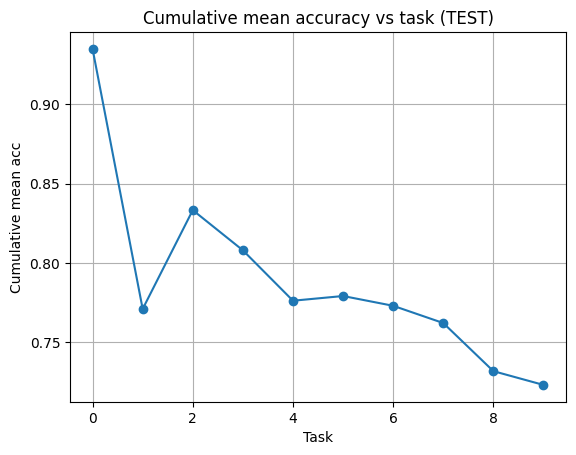

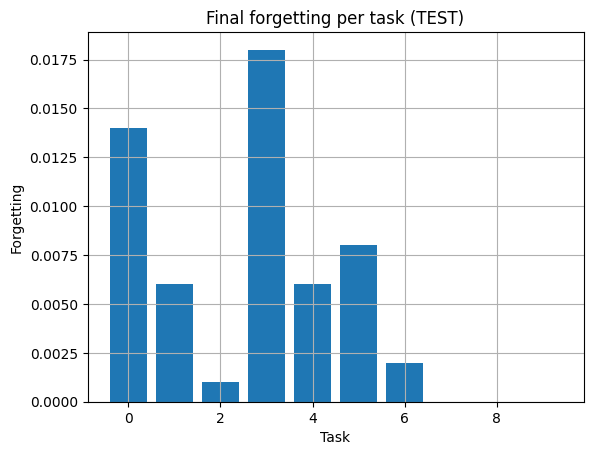

Saved artifacts to artifacts_v32_run.json


In [ ]:
# ============================================
# Cell 16: Run CoCoNAS v3.2 (Champion)
# ============================================
acc_mat, forgetting, best_heads, artifacts = run_all_tasks(save_json_path="artifacts_v32_run.json")


In [ ]:
# ============================================
# Cell 17: Baseline Shared Utilities (fixed)-----------------------------------------------------------------------------------UPdated

# ============================================
import torch
from torch.utils.data import DataLoader

def make_task_feature_loaders(task_id):
    ds_train, ds_val, ds_test_cur = make_task_splits(TASKS[task_id])

    # Precompute backbone features
    ds_train_z = FeatureDS(ds_train, backbone, bs=256)
    ds_val_z   = FeatureDS(ds_val,   backbone, bs=256)

    # Use CUDA-aware pin_memory; keep your seeded worker/generator if present
    loader_train_z = DataLoader(
        ds_train_z,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=2,
        pin_memory=torch.cuda.is_available(),
        drop_last=True,
        worker_init_fn=seed_worker if 'seed_worker' in globals() else None,
        generator=g if 'g' in globals() else None,
    )
    loader_val_z = DataLoader(
        ds_val_z,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=2,
        pin_memory=torch.cuda.is_available(),
        worker_init_fn=seed_worker if 'seed_worker' in globals() else None,
        generator=g if 'g' in globals() else None,
    )
    return ds_train_z, ds_val_z, loader_train_z, loader_val_z

@torch.no_grad()
def test_row_for_head(head, task_id, task_test_datasets):
    # Ensure eval mode for consistent metrics
    was_training = head.training
    head.eval()
    row_acc = []
    for i in range(task_id + 1):
        ds_test_i = task_test_datasets[i]
        loader_test_i = make_loader(ds_test_i, shuffle=False, bs=BATCH_SIZE)
        acc_i = eval_accuracy_any(None, head, loader_test_i, seen_classes=seen_up_to(i))
        row_acc.append(acc_i)
    if was_training:
        head.train()
    return row_acc


In [ ]:
# ============================================
# Cell 18 (FIXED): DER++ Baseline
# ============================================
class DERPPMemory:
    def __init__(self, capacity=EXEMPLAR_TOTAL_BUDGET):
        self.capacity = capacity
        self.Z, self.Y = [], []
    def add_batch(self, z, y):
        self.Z.append(z.detach().cpu()); self.Y.append(y.detach().cpu())
        Z = torch.cat(self.Z); Y = torch.cat(self.Y)
        if Z.size(0) > self.capacity:
            keep = self.capacity
            self.Z = [Z[-keep:]]; self.Y = [Y[-keep:]]
    def make_loader(self, bs=BATCH_SIZE):
        if not self.Z: return None
        Z = torch.cat(self.Z); Y = torch.cat(self.Y)
        class MemDS(Dataset):
            def __init__(self, Z, Y): self.Z=Z; self.Y=Y
            def __len__(self): return self.Y.size(0)
            def __getitem__(self,i): return self.Z[i], int(self.Y[i]), -1
        ds = MemDS(Z, Y)
        return DataLoader(ds, batch_size=bs, shuffle=True, num_workers=2, pin_memory=True,
                          drop_last=True, worker_init_fn=seed_worker, generator=g)

# CORRECTED DER++ TRAIN STEP: distill against frozen previous-task teacher
def derpp_train_step(head, opt, z_cur, y_cur, mem_loader=None, teacher_head=None, alpha=0.5, beta=0.5):
    head.train()
    logits = head(z_cur)
    loss_ce = F.cross_entropy(logits, y_cur)
    loss = loss_ce

    if mem_loader is not None:
        it = iter(mem_loader)
        try:
            z_mem, y_mem, _ = next(it)
            z_mem, y_mem = z_mem.to(DEVICE), y_mem.to(DEVICE)
            log_mem = head(z_mem)
            loss_mem_ce = F.cross_entropy(log_mem, y_mem)
            if teacher_head is not None:
                with torch.no_grad():
                    prev_logits = teacher_head(z_mem)  # logits from PREVIOUS task model
                mse = F.mse_loss(log_mem, prev_logits)
            else:
                mse = torch.tensor(0.0, device=DEVICE)
            loss = loss + alpha * loss_mem_ce + beta * mse
        except StopIteration:
            pass

    opt.zero_grad()
    loss.backward()
    nn.utils.clip_grad_norm_(head.parameters(), 1.0)
    opt.step()
    return float(loss.item())

def run_derpp_baseline(epochs_per_task=2, alpha=0.5, beta=0.5):
    print("\n=== DER++ Baseline ===")
    task_test_datasets = [make_test_dataset_for_task(TASKS[t]) for t in range(len(TASKS))]
    head = FCHead(in_dim=512, hidden=[256], p_drop=0.2, out_dim=NUM_CLASSES).to(DEVICE)
    opt  = torch.optim.AdamW(head.parameters(), lr=7e-4, weight_decay=1e-4)
    mem  = DERPPMemory(capacity=EXEMPLAR_TOTAL_BUDGET)
    teacher_head = None  # frozen copy after each task

    acc_history_rows = []; val_acc_history_rows = []
    for t in range(len(TASKS)):
        print(f"\n-- Task {t+1}/{len(TASKS)} --")
        ds_train_z, ds_val_z, loader_train_z, loader_val_z = make_task_feature_loaders(t)

        # Train current task
        for _ in range(epochs_per_task):
            for z,y,_ in loader_train_z:
                z, y = z.to(DEVICE), y.to(DEVICE)
                mem_loader = mem.make_loader()
                _ = derpp_train_step(
                    head, opt, z, y,
                    mem_loader=mem_loader,
                    teacher_head=teacher_head,
                    alpha=alpha, beta=beta
                )
                mem.add_batch(z, y)

        # Freeze teacher for next task
        teacher_head = copy.deepcopy(head).eval()
        for p in teacher_head.parameters(): p.requires_grad = False

        # TEST cumulative
        row = test_row_for_head(head, t, task_test_datasets); acc_history_rows.append(row)
        print("TEST row:", [round(a,3) for a in row])

        # VAL audit row (same protocol as CoCoNAS)
        row_val=[]
        for i in range(t+1):
            ds_val_i = ds_val_z if i==t else FeatureDS(make_task_splits(TASKS[i])[1], backbone)
            loader_val_i = make_loader(ds_val_i, shuffle=False, bs=BATCH_SIZE)
            row_val.append(eval_accuracy_any(None, head, loader_val_i, seen_classes=seen_up_to(i)))
        val_acc_history_rows.append(row_val)

    return acc_history_rows, val_acc_history_rows, head


In [ ]:
# ============================================
# Cell 19: iCaRL Baseline (scaffold)
# ============================================
class ICaRLExemplars:
    def __init__(self, budget=EXEMPLAR_TOTAL_BUDGET):
        self.budget = budget
        self.store  = {}  # c -> [z_cpu, ...]
    def size(self): return sum(len(v) for v in self.store.values())
    def add_class_exemplars(self, class_z_list, m):
        # take m exemplars (herding could be added; random simple)
        keep = class_z_list[:m]
        return [z.cpu() for z in keep]
    @torch.no_grad()
    def update(self, ds_train_z, new_classes, seen_classes):
        # compute class means over ds_train_z for new classes
        per_class = {c: [] for c in new_classes}
        for i in range(len(ds_train_z)):
            z, y, _ = ds_train_z[i]
            if int(y) in new_classes:
                per_class[int(y)].append(z)
        # distribute budget uniformly over seen classes
        if len(seen_classes) == 0: return
        m = max(1, self.budget // len(seen_classes))
        # truncate existing
        for c in list(self.store.keys()):
            self.store[c] = self.store[c][:m]
        # add for new classes
        for c in new_classes:
            zs = per_class[c]
            if len(zs)==0: continue
            self.store[c] = self.add_class_exemplars(zs, m)
        # ensure budget
        total = self.size()
        if total > self.budget:
            for c in list(self.store.keys()):
                self.store[c] = self.store[c][:m]
    @torch.no_grad()
    def classify(self, z, seen_classes):
        # nearest-mean-of-exemplars
        means = {}
        for c in seen_classes:
            zs = self.store.get(c, [])
            if len(zs)==0: continue
            Z = torch.stack(zs).to(DEVICE)
            means[c] = Z.mean(0)
        if not means:
            return torch.zeros(z.size(0), dtype=torch.long, device=DEVICE)
        C = sorted(means.keys())
        M = torch.stack([means[c] for c in C])  # [C, D]
        # cosine similarity
        z_n = F.normalize(z, dim=1); M_n = F.normalize(M, dim=1)
        S = torch.mm(z_n, M_n.t())  # [B, C]
        idx = S.argmax(1)
        pred = torch.tensor([C[i.item()] for i in idx], device=DEVICE)
        return pred

def run_icarl_baseline():
    print("\n=== iCaRL Baseline ===")
    task_test_datasets = [make_test_dataset_for_task(TASKS[t]) for t in range(len(TASKS))]
    head = FCHead(in_dim=512, hidden=[256], p_drop=0.2, out_dim=NUM_CLASSES).to(DEVICE)
    opt  = torch.optim.AdamW(head.parameters(), lr=7e-4, weight_decay=1e-4)
    memory = ICaRLExemplars(budget=EXEMPLAR_TOTAL_BUDGET)

    acc_history_rows = []; val_acc_history_rows = []
    seen_classes = []
    for t in range(len(TASKS)):
        print(f"\n-- Task {t+1}/{len(TASKS)} --")
        task_classes = TASKS[t]
        ds_train_z, ds_val_z, loader_train_z, loader_val_z = make_task_feature_loaders(t)
        seen_classes = list(sorted(set(seen_classes + task_classes)))

        # simple CE training on current classes (feature space)
        for epoch in range(2):
            for z,y,_ in loader_train_z:
                z, y = z.to(DEVICE), y.to(DEVICE)
                logits = head(z)
                loss = F.cross_entropy(mask_unseen_logits(logits, seen_classes), y)
                opt.zero_grad(); loss.backward(); nn.utils.clip_grad_norm_(head.parameters(), 1.0); opt.step()

        # update exemplars
        memory.update(ds_train_z, new_classes=task_classes, seen_classes=seen_classes)

        # TEST cumulative (using classifier = NME over exemplars in Z)
        row=[]
        for i in range(t+1):
            ds_test_i = task_test_datasets[i]
            loader_test_i = make_loader(ds_test_i, shuffle=False, bs=BATCH_SIZE)
            correct=total=0
            with torch.no_grad():
                for x,y,_ in loader_test_i:
                    z = backbone(x.to(DEVICE))
                    pred = memory.classify(z, seen_classes=seen_up_to(i))
                    correct += (pred==y.to(DEVICE)).sum().item(); total += y.numel()
            row.append(correct/max(1,total))
        acc_history_rows.append(row)
        print("TEST row:", [round(a,3) for a in row])

        # VAL audit row similarly
        row_val=[]
        for i in range(t+1):
            # evaluate NME on VAL features
            ds_val_i = ds_val_z if i==t else FeatureDS(make_task_splits(TASKS[i])[1], backbone)
            loader_val_i = make_loader(ds_val_i, shuffle=False, bs=BATCH_SIZE)
            correct=total=0
            with torch.no_grad():
                for z,y,_ in loader_val_i:
                    z = z.to(DEVICE)
                    pred = memory.classify(z, seen_classes=seen_up_to(i))
                    correct += (pred==y.to(DEVICE)).sum().item(); total += y.numel()
            row_val.append(correct/max(1,total))
        val_acc_history_rows.append(row_val)

    return acc_history_rows, val_acc_history_rows, head, memory





=== DER++ Baseline ===

-- Task 1/10 --
TEST row: [0.946]

-- Task 2/10 --
TEST row: [0.915, 0.888]

-- Task 3/10 --
TEST row: [0.896, 0.856, 0.889]

-- Task 4/10 --
TEST row: [0.888, 0.845, 0.907, 0.88]

-- Task 5/10 --
TEST row: [0.872, 0.823, 0.879, 0.88, 0.897]

-- Task 6/10 --
TEST row: [0.877, 0.811, 0.859, 0.86, 0.879, 0.853]

-- Task 7/10 --
TEST row: [0.875, 0.81, 0.841, 0.83, 0.868, 0.849, 0.868]

-- Task 8/10 --
TEST row: [0.864, 0.797, 0.838, 0.808, 0.853, 0.833, 0.855, 0.886]

-- Task 9/10 --
TEST row: [0.826, 0.789, 0.779, 0.761, 0.823, 0.826, 0.84, 0.891, 0.904]

-- Task 10/10 --
TEST row: [0.814, 0.781, 0.801, 0.754, 0.821, 0.804, 0.828, 0.869, 0.881, 0.926]

=== iCaRL Baseline ===

-- Task 1/10 --
TEST row: [0.863]

-- Task 2/10 --
TEST row: [0.863, 0.752]

-- Task 3/10 --
TEST row: [0.848, 0.762, 0.722]

-- Task 4/10 --
TEST row: [0.844, 0.753, 0.719, 0.626]

-- Task 5/10 --
TEST row: [0.852, 0.76, 0.717, 0.624, 0.609]

-- Task 6/10 --
TEST row: [0.843, 0.773, 0.702,

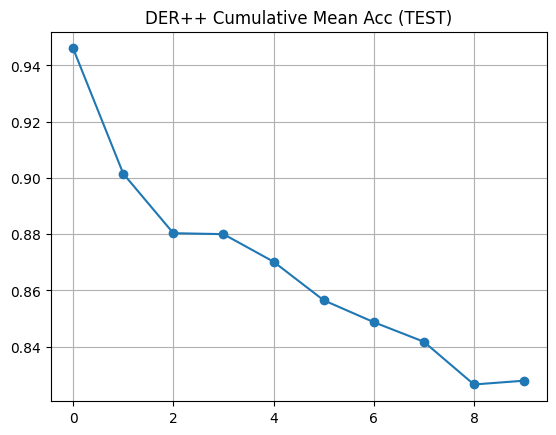


=== iCaRL Summary (TEST) ===
Final cumulative mean acc: 0.6045
Forgetting per task: [0.042, 0.032, 0.032, 0.053, 0.014, 0.028, 0.006, 0.031, 0.007, 0.0]


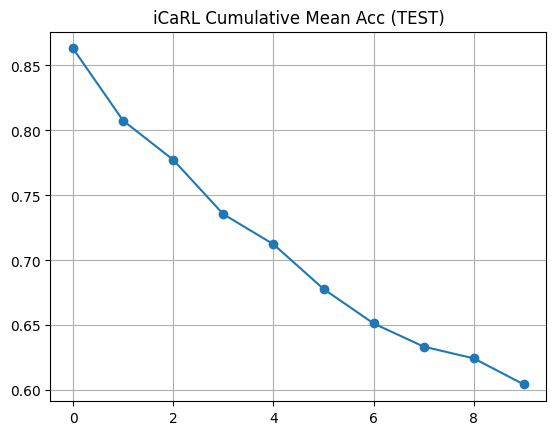

In [ ]:
# ============================================
# Cell 20: Run Baselines (DER++ & iCaRL)
# ============================================
# You can tune epochs_per_task if you want a stronger DER++
der_test_rows, der_val_rows, der_head = run_derpp_baseline(epochs_per_task=2, alpha=0.5, beta=0.5)
icarl_test_rows, icarl_val_rows, icarl_head, icarl_mem = run_icarl_baseline()

# Quick summaries
def summarize_rows(rows, name):
    Tn = len(rows)
    acc_mat = np.full((Tn, Tn), np.nan)
    for t,row in enumerate(rows): acc_mat[t,:len(row)] = row
    final_row = acc_mat[Tn-1,:]
    max_prev  = np.nanmax(acc_mat, axis=0)
    forgetting = max_prev - final_row
    print(f"\n=== {name} Summary (TEST) ===")
    print("Final cumulative mean acc:", float(np.nanmean(final_row)))
    print("Forgetting per task:", [float(round(x,3)) for x in forgetting[:Tn]])
    plt.figure(); plt.plot([np.nanmean(acc_mat[t,:t+1]) for t in range(Tn)], marker='o'); plt.title(f"{name} Cumulative Mean Acc (TEST)"); plt.grid(True); plt.show()

summarize_rows(der_test_rows, "DER++")
summarize_rows(icarl_test_rows, "iCaRL")
